In [1]:
from cmath import log, log10, pi
import imageio
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))


In [2]:
# Carga de imagen

img_rgb = imageio.imread('imageio:coffee.png')/255
img_gris = rgb2yiq(img_rgb)[:,:,0]   # imagen en YIQ y eligiendo canal Y

In [3]:
N, M = img_gris.shape
TF = np.fft.fftshift(np.fft.fft2(img_gris))/(N*M) # se aplica Fourier y se toma modulo y fase

Xmod = np.abs(TF)
Xph = np.angle(TF)

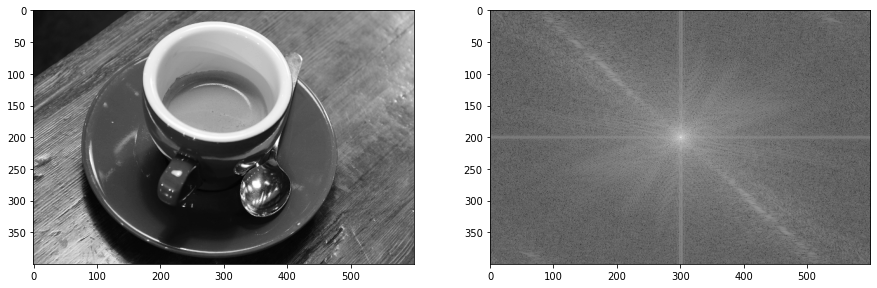

In [4]:
#escala logaritmica

Xmod_log = np.log10(Xmod)
_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gris,'gray')
axes[1].imshow(Xmod_log,'gray')

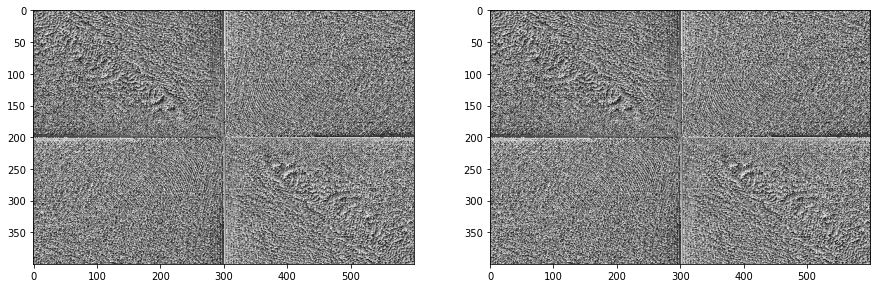

In [5]:
import cmath

# fase 
# transformación no lineal fase

Xph_mod = (Xph + cmath.pi)*(255/(2*cmath.pi))
imageio.imsave('fase coffee.png',np.uint8(Xph_mod),'png') # se guarda la imagen en 8 bits y como PNG
Xph2 = imageio.imread('fase coffee.png') # se carga la misma imagen

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(Xph,'gray')
axes[1].imshow(Xph2,'gray')

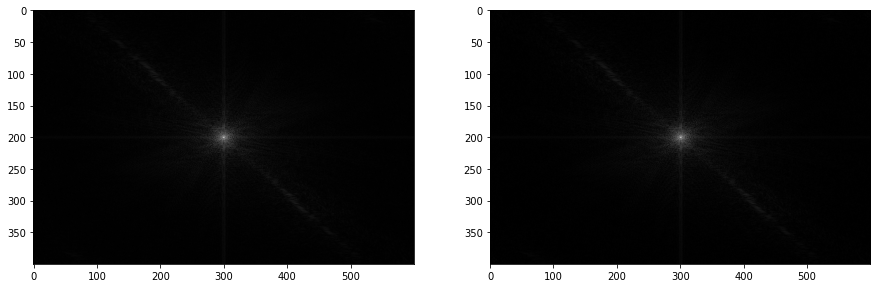

In [6]:
# transformación no lineal modulo

x = 1000
Xmod_transf = np.log10((x*Xmod)+1)/np.log10((x+1))     #se aplica la transformada
Xmod_transf = 255*Xmod_transf                            #se pasa el resultado de 0 a 255

imageio.imsave('modulo coffee.png',np.uint8(Xmod_transf),'png') # se guarda la imagen en 8 bits y como PNG
Xmod_red = imageio.imread('modulo coffee.png') # se carga la misma imagen

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(Xmod_transf,'gray')
axes[1].imshow(Xmod_red,'gray')
plt.show()


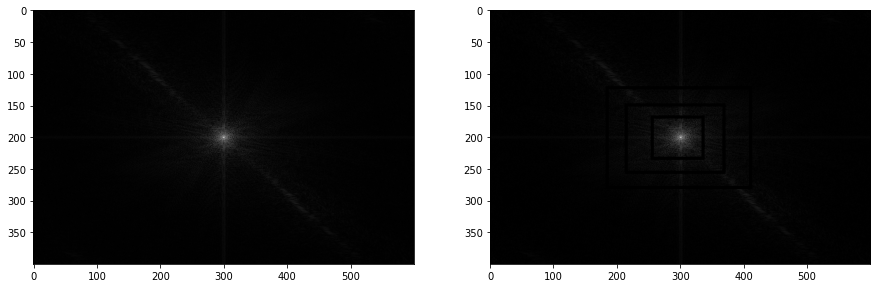

In [7]:

# modificación del espectro

Xmod_red= imageio.imread('modulo modificado coffee.png')[:,:,0] # se carga la imagen modificada tomando filas y columnas y solamente la tercer componente 
_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(Xmod_transf,'gray')
axes[1].imshow(Xmod_red,'gray')
plt.show()



In [8]:
#inversa 

rows = Xmod_red.shape[0]
cols = Xmod_red.shape[1]

# inv en mod

Xmod2_inv = ((10**((Xmod_red/255)*np.log10(x+1)))-1)/x # se aplica la transformacion inversa al modulo
E = np.zeros(Xph2.shape, dtype=complex) # se crea una matriz vacía para asignar en el bucle iterativo

# inv en phase

Xph2_inv = ((Xph2*(2*cmath.pi))/255)-cmath.pi

# se unen modulo y fase: Espectro(pixel x) = Espectro(modulo pixel x)* cos( Espectro(fase pixel x)) + Espectro(fase pixel x)* sin( Espectro(fase pixel x))

for i in range(rows): 
    for j in range(cols):
        E[i,j] = complex(Xmod2_inv[i,j]*np.cos(Xph2_inv[i,j]),Xmod2_inv[i,j]*np.sin(Xph2_inv[i,j])) 
       

# se calcula la parte real, ya que la antitransformada devuelve también una parte compleja residual (no deseada).

img_modificada = np.real((np.fft.ifft2(np.fft.ifftshift(E))))*(N*M) 

# se calcula el error entre la original y la reconstruida

print("El error respecto a la imagen original resulta: ", rmse(img_gris,img_modificada))

El error respecto a la imagen original resulta:  0.02502919003282439


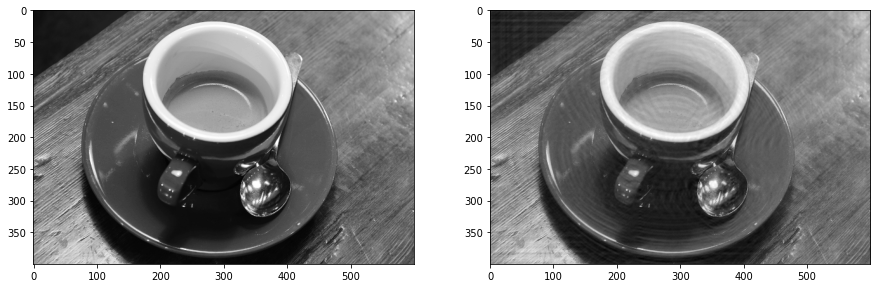

In [9]:
# se grafica la imagen original y la reconstruida

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_gris,'gray')
axes[1].imshow(img_modificada,'gray')
plt.show()

# se observa la pérdida de algunos detalles en la imagen luego de modificar su espectro en módulo
